# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [C](#C)
* [Discussion](#Discussion)

# Introduction

tune a logreg

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.68 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = (
    "../24.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_song_data"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "./tune_logreg"

_ = gc_collect()

time: 148 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather("./scaled_features_ready_for_selection.feather").set_index(
        "id"
    )
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 199 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     85740 non-null  float64
 1   LDA2                     85740 non-null  float64
 2   ocSVM_sgdlinear_neg      85740 non-null  float64
 3   ocSVM_sgdlinear_neu      85740 non-null  float64
 4   ocSVM_sgdlinear_pos      85740 non-null  float64
 5   LDA-LOF_neg_20           85740 non-null  float64
 6   LDA-LOF_neu_20           85740 non-null  float64
 7   LDA-LOF_pos_20           85740 non-null  float64
 8   LDA-ocSVM_rbf_neg        85740 non-null  float64
 9   LDA-ocSVM_rbf_neu        85740 non-null  float64
 10  LDA-ocSVM_rbf_pos        85740 non-null  float64
 11  LDA-ocSVM_sgdlinear_neg  85740 non-null  float64
 12  LDA-ocSVM_sgdlinear_neu  85740 non-null  float64
 13  LDA-ocSVM_sgdlinear_pos  85740 non-null  float64
dtypes: float64(14)
memory

# Strata

In [7]:
N_SPLITS = 8

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 85740/85740 [00:01<00:00, 77606.02it/s]

time: 1.22 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 127 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 52
only 2: 37
only 3: 31
only 4: 17
only 5: 27
only 6: 13
only 7: 9
merge passes performed: 1
only 1: 43
only 2: 24
only 3: 4
only 4: 1
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 2
only 1: 42
only 2: 20
only 3: 0
only 4: 0
only 5: 5
only 6: 0
only 7: 0
merge passes performed: 3
only 1: 37
only 2: 0
only 3: 0
only 4: 10
only 5: 0
only 6: 5
only 7: 0
merge passes performed: 4
only 1: 32
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 5
merge passes performed: 5
only 1: 27
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 6
only 1: 1
only 2: 1
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 1
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 8
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdfsur0engmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdmang0cmnmedium                1750
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdmsur0cmnmedium                1749
esdmsur0engmedium                1749
esdfang0engmedium                1748
esdfang0cmnmedium                1747
esdmneu1engmedium                1747
esdmang0engmedium                1746
esdfsad0engmedium                1744
esdmhap2engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 2.24 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=LogisticRegression(
        # tol=1e-5,
        class_weight="balanced",
        random_state=SEED,
        solver="lbfgs",
        max_iter=1000,
        verbose=1,
        n_jobs=-1,
    ),
    param_distributions={
        "C": loguniform(1e-5, 1e5),
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED,
    error_score="raise",
).fit(data, labels.valence)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


time: 1min 25s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished


-0.7823970695139222
{'C': 0.9785389306670665}


<AxesSubplot:xlabel='param_C'>

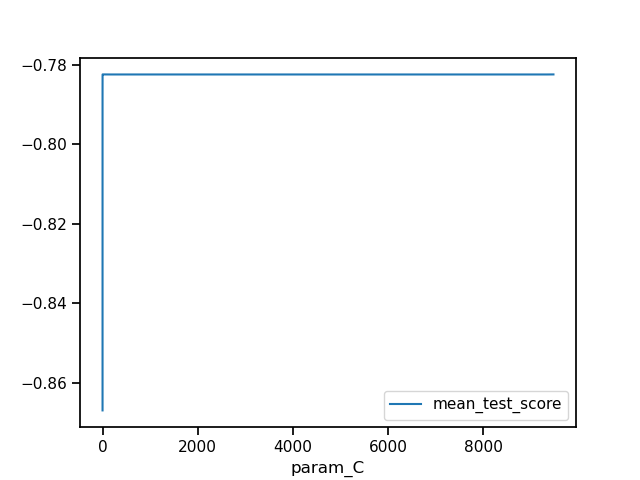

time: 215 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_C", ascending=True)
    .loc[:, ["param_C", "mean_test_score"]]
)
results_df.plot(x="param_C", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
1,9.468461,1.174908,0.015018,0.002909,0.978539,{'C': 0.9785389306670665},-0.709519,-0.905281,-0.932329,-0.803722,-0.913251,-0.677039,-0.647013,-0.671021,-0.782397,0.113083,1
5,8.447704,0.868143,0.015888,0.007276,0.741107,{'C': 0.741106602081463},-0.709496,-0.905271,-0.932345,-0.803739,-0.913266,-0.677039,-0.647020,-0.671023,-0.782400,0.113088,2
7,9.749855,1.024177,0.016608,0.007143,29.820897,{'C': 29.820897324403727},-0.709515,-0.905281,-0.932334,-0.803686,-0.913324,-0.677067,-0.646993,-0.671025,-0.782403,0.113093,3
6,9.209368,0.871144,0.017976,0.006274,9474.848281,{'C': 9474.84828131499},-0.709517,-0.905292,-0.932335,-0.803703,-0.913326,-0.677083,-0.646951,-0.671024,-0.782404,0.113100,4
4,9.313392,0.703555,0.015510,0.004579,71.462128,{'C': 71.46212766206634},-0.709549,-0.905278,-0.932285,-0.803712,-0.913316,-0.677063,-0.646998,-0.671050,-0.782406,0.113078,5
9,8.582341,0.450879,0.013195,0.004272,162.685667,{'C': 162.6856667815611},-0.709510,-0.905275,-0.932342,-0.803712,-0.913337,-0.677078,-0.647020,-0.671043,-0.782415,0.113089,6
8,9.774016,0.925684,0.014444,0.006496,9324.621837,{'C': 9324.6218374883},-0.709544,-0.905296,-0.932340,-0.803711,-0.913331,-0.677048,-0.646987,-0.671067,-0.782416,0.113094,7
2,1.617882,0.154822,0.014009,0.003515,0.000136,{'C': 0.000136093348365246},-0.731038,-0.889031,-0.920090,-0.806044,-0.891719,-0.696995,-0.673396,-0.693257,-0.787696,0.095115,8
3,1.345432,0.106202,0.016877,0.006437,0.000032,{'C': 3.160386382061093e-05},-0.782462,-0.891572,-0.921934,-0.836930,-0.892086,-0.748251,-0.733311,-0.747825,-0.819296,0.070952,9
0,1.255587,0.101333,0.015296,0.003398,0.000012,{'C': 1.2404696357832288e-05},-0.844028,-0.917713,-0.943419,-0.884349,-0.915714,-0.812457,-0.804359,-0.813093,-0.866892,0.051742,10


time: 50.7 ms


In [13]:
def tune(C: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=LogisticRegression(
            class_weight="balanced",
            random_state=SEED + 1,
            max_iter=1000,
            verbose=1,
            n_jobs=-1,
        ),
        param_distributions={"C": C},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_C", ascending=True)
        .loc[:, ["param_C", "mean_test_score"]]
    )
    df.plot(x="param_C", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_C", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 144 ms


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7823568484628975
best params: {'C': 0.2396348037505133}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


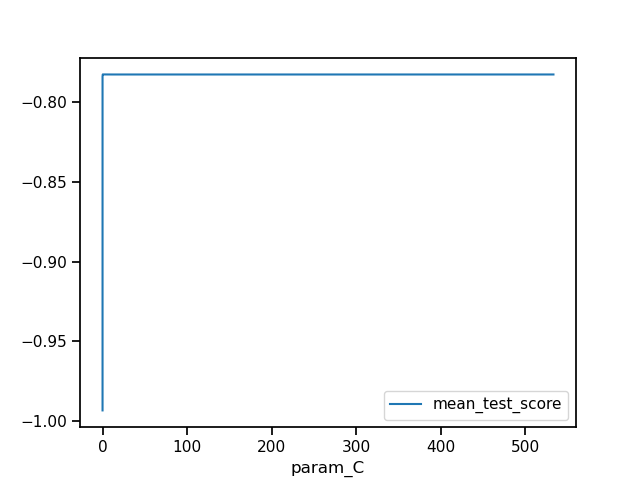

time: 1min 13s


In [14]:
df = tune(C=loguniform(1e-6, 1e6), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7822677932108444
best params: {'C': 0.004366682535082346}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


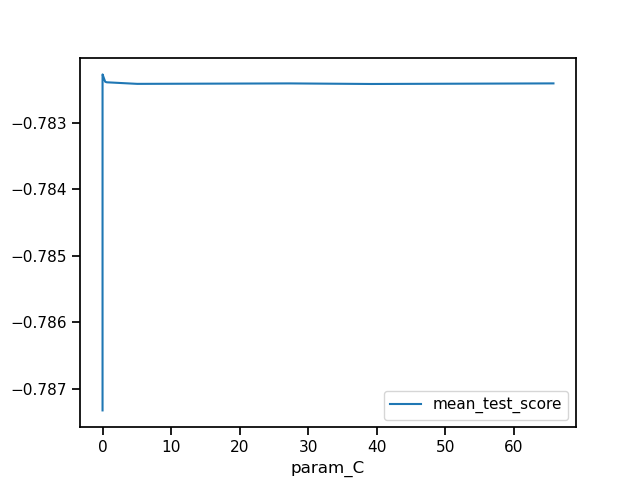

time: 1min 10s


In [15]:
df = tune(C=loguniform(1e-4, 1e4), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7823351519842849
best params: {'C': 0.1192415990850905}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


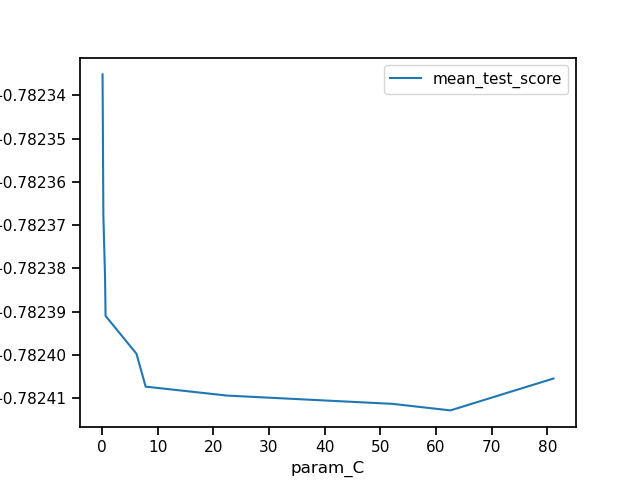

time: 1min 47s


In [16]:
df = tune(C=loguniform(0.1, 1000), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7822541432985721
best params: {'C': 0.007859280943131399}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


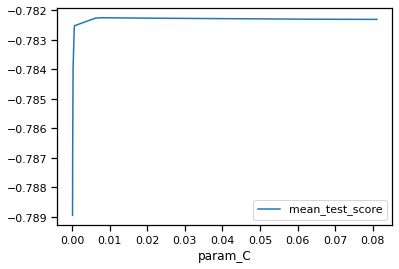

time: 1min


In [18]:
df = tune(C=loguniform(1e-4, 1), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7822645269247535
best params: {'C': 0.004779698731533934}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


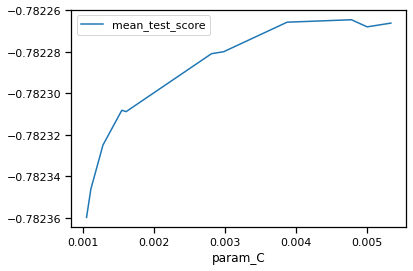

time: 51.6 s


In [19]:
df = tune(C=loguniform(1e-3, 1e-2), results_df=df, n_iter=11)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished


best score: -0.7822530990675945
best params: {'C': 0.017091237161580453}


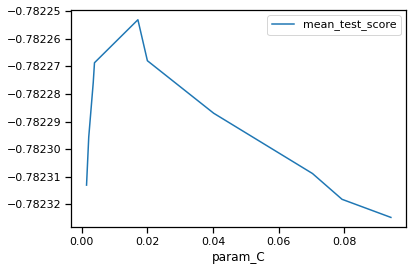

time: 1min 11s


In [20]:
df = tune(C=loguniform(0.0011, 0.5), results_df=df, n_iter=10)

Fitting 8 folds for each of 17 candidates, totalling 136 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7822504293540642
best params: {'C': 0.00886525856539526}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


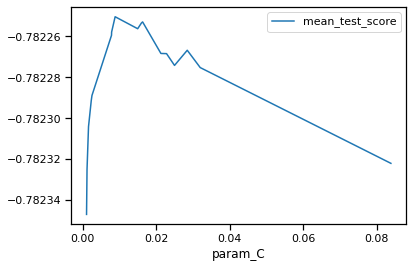

time: 1min 52s


In [21]:
df = tune(C=loguniform(0.001, 0.1), results_df=df, n_iter=17)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7822484742233591
best params: {'C': 0.011514411442955409}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


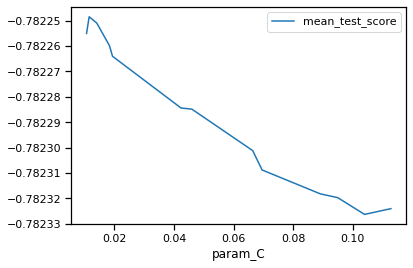

time: 1min 52s


In [22]:
df = tune(C=loguniform(0.01, 0.25), results_df=df, n_iter=13)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.782251887676185
best params: {'C': 0.013685276302566779}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


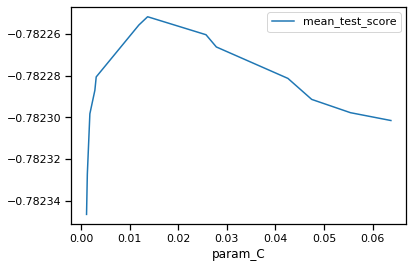

time: 1min 24s


In [23]:
df = tune(C=loguniform(0.001, 0.25), results_df=df, n_iter=13)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


best score: -0.7822508184640709
best params: {'C': 0.010777788260091068}


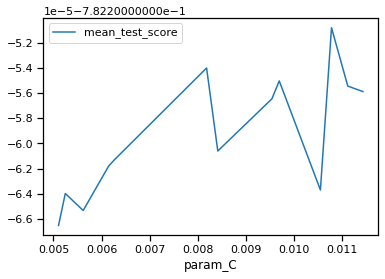

time: 1min 31s


In [28]:
df = tune(C=loguniform(0.005, 0.015), results_df=df, n_iter=13)

In [29]:
_ = gc_collect()

time: 135 ms


In [30]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/logreg_results.csv")

time: 4.99 ms


<AxesSubplot:xlabel='param_C'>

,param_C,mean_test_score
3,0.011514,-0.782248
8,0.008865,-0.782250
1,0.010778,-0.782251
5,0.014069,-0.782251
8,0.013685,-0.782252
15,0.01634,-0.782253
9,0.017091,-0.782253
12,0.016029,-0.782253
9,0.008182,-0.782254
8,0.007859,-0.782254


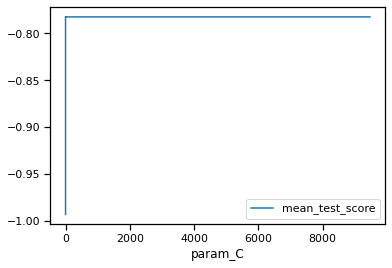

time: 257 ms


In [31]:
results_df = results_df.sort_values(by="param_C", ascending=True)
results_df.plot(x="param_C", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [32]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[results_df.mean_test_score == max_score].param_C.iloc[0]

,param_C,mean_test_score
3,0.011514,-0.782248


0.011514411442955409

time: 12.5 ms


<AxesSubplot:xlabel='param_C'>

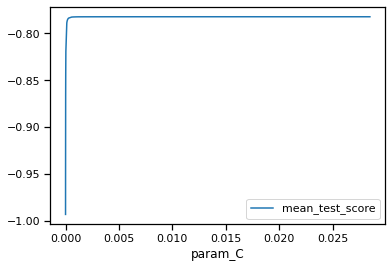

time: 215 ms


In [38]:
results_df.loc[results_df.param_C < 0.03].plot(x="param_C", y="mean_test_score")

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [33]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1221.100406885147 s
time: 226 ms


[^top](#Contents)